In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
# standard python packages
import os, sys
from glob import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import h5py
import seaborn as sns
from sklearn import datasets
    
import random
import math
import json

In [3]:
sys.path.insert(0, os.getcwd())
from deviance import explained_deviance

### Deviance explained $D^2$

In [4]:
y_true = np.random.randint(0,2,100)
print("sanity check. D2 should be 1.0 when y_pred = y_true. We get D2 = {:.2f}.".format(
    explained_deviance(y_true, y_pred_probas=y_true)))

sanity check. D2 should be 1.0 when y_pred = y_true. We get D2 = 1.00.


### Extensively test all edge cases: 
1. when predictions are perfect 
2. when predictions are exactly opposite

In [5]:
from sklearn.preprocessing import OneHotEncoder

for n_classes in range(2,10):
    print('-'*30, f"\nclasses n={n_classes}" )
    y_true = np.random.randint(0,n_classes+1,1000)
    print(f"perfect prediction (y_true = y_pred):")
    y_pred_probas = OneHotEncoder().fit(y_true.reshape(-1,1)).transform(y_true.reshape(-1,1)).toarray()
    d2 = explained_deviance(y_true, y_pred_probas=y_pred_probas)
    d2_logits = explained_deviance(y_true, y_pred_logits=y_pred_probas*1000)
    print(f"Probas = {d2:.6f} \t logits = {d2_logits:.6f}")
    print(f"perfectly incorrect prediction (y_true = not(y_pred)):")
    y_pred_probas = np.roll(y_pred_probas, 1, -1)
    d2 = explained_deviance(y_true, y_pred_probas=y_pred_probas)
    d2_logits = explained_deviance(y_true, y_pred_logits=y_pred_probas*1000)
    print(f"Probas = {d2:.6f} \t logits = {d2_logits:.6f}")
    print(f"y_pred is always average (1/n_classes):")
    y_pred_probas = np.full_like(y_pred_probas, fill_value=1/n_classes)
    d2 = explained_deviance(y_true, y_pred_probas=y_pred_probas)
    d2_logits = explained_deviance(y_true, y_pred_logits=y_pred_probas*1000)
    print(f"Probas = {d2:.6f} \t logits = {d2_logits:.6f}")


------------------------------ 
classes n=2
perfect prediction (y_true = y_pred):
Probas = 1.000000 	 logits = 1.000000
perfectly incorrect prediction (y_true = not(y_pred)):
Probas = -30.465134 	 logits = -24.172107
y_pred is always average (1/n_classes):
Probas = -0.000846 	 logits = -0.000846
------------------------------ 
classes n=3
perfect prediction (y_true = y_pred):
Probas = 1.000000 	 logits = 1.000000
perfectly incorrect prediction (y_true = not(y_pred)):
Probas = -23.930318 	 logits = -18.944254
y_pred is always average (1/n_classes):
Probas = -0.000636 	 logits = -0.000636
------------------------------ 
classes n=4
perfect prediction (y_true = y_pred):
Probas = 1.000000 	 logits = 1.000000
perfectly incorrect prediction (y_true = not(y_pred)):
Probas = -20.476532 	 logits = -16.181226
y_pred is always average (1/n_classes):
Probas = -0.000763 	 logits = -0.000763
------------------------------ 
classes n=5
perfect prediction (y_true = y_pred):
Probas = 1.000000 	 logits 

### Synthetic data: how does the probability value effect the D2?



/ritter/roshan/installations/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


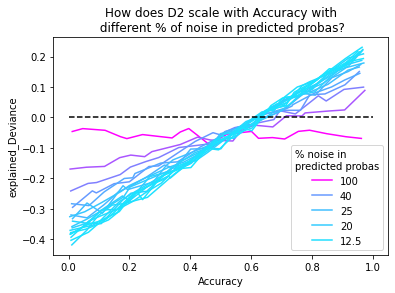

In [6]:
from sklearn.metrics import balanced_accuracy_score, accuracy_score
import time

# create binary labels with increasing correlation between y_true and y_pred_probas
n_classes = 2
for proba_noise_mul in np.arange(1, 10, 0.5):
    proba_noise = 1/(proba_noise_mul)
    accs = []
    d2s = []
    for corr in np.arange(0.01, 1.01, 0.05):
        y_true = np.random.randint(0,2,1000)
        mask_valreverse = np.random.choice([True, False], size=y_true.shape, p=[1-corr, corr])
        y_pred = y_true.copy()

        # reverse values of some y proportional to the corr
        y_pred[mask_valreverse] =  np.logical_not(y_true[mask_valreverse].astype(bool)).astype(int)
        acc = balanced_accuracy_score(y_true, y_pred)
        accs.extend([acc])
        # convert y_pred to y_pred_probas by adding random noise
        y_pred_probas = y_pred.copy().astype(float)
        # print(y_pred, y_pred_logits[~y_pred.astype(bool)], len(y_pred_logits[~y_pred.astype(bool)]))
        y_pred_probas[y_pred.astype(bool)] -= np.random.sample(y_pred[y_pred.astype(bool)].shape)*proba_noise
        y_pred_probas[~y_pred.astype(bool)] += np.random.sample(y_pred[~y_pred.astype(bool)].shape)*proba_noise
        # plt.hist(y_pred_probas)
        # plt.show()
        # print(f"The y_pred_logits values range from [{y_pred_probas.min():.2f},{y_pred_probas.max():.2f}]")
        # print(((y_pred_probas>0.5).astype(int) == y_pred).sum())
        d2 = explained_deviance(y_true, y_pred_logits=y_pred_probas)
        d2s.extend([d2])
        # print("Accuracy (bal) = {:.2f} % \t D2 explained = {:.2f} %".format(acc*100, d2*100))
    g = sns.lineplot(x=accs, y=d2s, 
                     hue=proba_noise*100, palette="cool", hue_norm=(0,100),
                     legend='brief')
    # print(f"The D2 values range from [{np.array(d2s).min():.2f},{np.array(d2s).max():.2f}] for proba_noise={proba_noise:.2f}")

sns.lineplot(np.arange(0,1.1,0.1), 11*[0], color='k', ls='--')
g.set(title='How does D2 scale with Accuracy with\n different % of noise in predicted probas?', xlabel='Accuracy', ylabel='explained_Deviance')
plt.legend(title='% noise in \npredicted probas')
plt.show()

### Real data: Compare our results against Statsmodel's pseudo-r-squared
Ground truth evaluation on some real world data

In [7]:
import statsmodels.api as sm

--------------------------------------------------
Test data = testdata1.csv


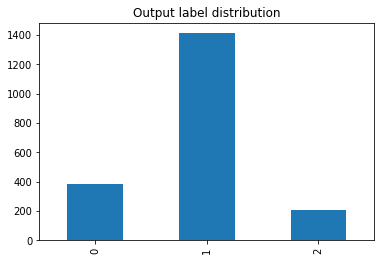

Optimization terminated successfully.
         Current function value: 0.792396
         Iterations 7
(runtime:: 0.38226)
MNLogit Accuracy (bal) = 33.33 % 	 (chance at 100.0%)
MNLogit D2 explained  (sm)  = 0.005475 				 llf=-1584.7924994969253,  llnull=-1593.516901467241
MNLogit D2 explained (ours) = 0.005475  (runtime:: 0.09104) 	 llf=-1584.792499496925,  llnull=-1593.5169013930033
--------------------------------------------------
Test data = testdata0.csv


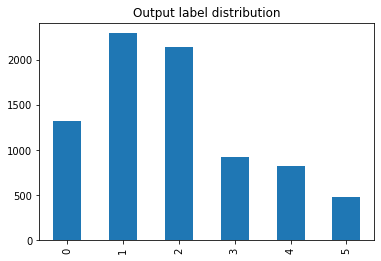

Optimization terminated successfully.
         Current function value: 1.641724
         Iterations 6
(runtime:: 1.63405)
MNLogit Accuracy (bal) = 18.22 % 	 (chance at 100.0%)
MNLogit D2 explained  (sm)  = 0.012173 				 llf=-13133.790432887894,  llnull=-13295.64026258147
MNLogit D2 explained (ours) = 0.012173  (runtime:: 0.24697) 	 llf=-13133.790432887896,  llnull=-13295.640262109953


In [8]:
for testdata in glob('test*.csv'):
    print(f"{'-'*50}\nTest data = {testdata}")
    testdata = pd.read_csv(testdata).set_index('ID')

    X = testdata.filter(like='Input-').values
    y_true = testdata['Output'].values.astype(int)
    y_pred_probas = testdata.filter(like='Pred-').values

    pd.Series(y_true).value_counts().sort_index().plot.bar(title='Output label distribution')
    plt.show()

    n_classes = y_pred_probas.shape[-1]
    y_pred_DL_probas = np.argmax(y_pred_probas, -1)

    # deviance score after fitting a logit model from statsmodel
    # if n_classes>2:
    #     y_pred = OneHotEncoder(sparse=False).fit_transform(y_pred.reshape(-1,1))
    # else:
    #     logit = sm.Logit

    X = sm.add_constant(X, prepend=False)
    start = time.process_time()
    d2_glm = sm.MNLogit(y_true, X).fit() 
    print("(runtime:: {:.5f})".format(time.process_time() - start))
    # d2_glm = sm.GLM(y_true, X, family=sm.families.Binomial()).fit() 
    # display(d2_glm.summary())

    y_pred_glm_probas = d2_glm.predict(X)
    y_pred_glm = np.argmax(y_pred_glm_probas, -1)

    # ground truth as accuracy 
    print("MNLogit Accuracy (bal) = {:.2f} % \t (chance at {:.1f}%)".format(
        balanced_accuracy_score(y_true, y_pred_glm)*100, 
        100/n_classes))

    print("MNLogit D2 explained  (sm)  = {:.6f} \t\t\t\t llf={},  llnull={}".format(
        d2_glm.prsquared, d2_glm.llf, d2_glm.llnull))
    # our deviance score
    start = time.process_time()
    d2, lls  = explained_deviance(y_true, y_pred_probas=y_pred_glm_probas, returnloglikes=True)
    print("MNLogit D2 explained (ours) = {:.6f}  (runtime:: {:.5f}) \t llf={},  llnull={}".format(
        d2, time.process_time()-start, lls['loglike_model'], lls['loglike_null']))